In [1]:
import json
import pandas as pd
from collections import defaultdict
from nltk.tokenize import word_tokenize
import pickle
import h5py
import re
from utils import img_data_2_mini_batch, imgs2batch
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data as Data
from torchvision import transforms
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image
import functools as ft

%matplotlib inline
import torch.nn.functional as F
import sys, os
from IPython.display import display, HTML
%reload_ext autoreload
%autoreload 2

In [2]:
from data_loader import VQADataSet
pp = lambda parsed: print(json.dumps(parsed, indent=4, sort_keys=True))
N = 2000

In [3]:
dataset_filename = "./data_{}.pkl".format(N)
dataset = None
print(dataset_filename)
if (os.path.exists(dataset_filename)):
    with open(dataset_filename, 'rb') as handle:
        print("reading from " + dataset_filename)
        dataset = pickle.load(handle)
else:
    dataset = VQADataSet(Q=N)
    with open(dataset_filename, 'wb') as handle:
        print("writing to " + dataset_filename)
        pickle.dump(dataset, handle)

assert(dataset is not None)

./data_2000.pkl


100%|██████████| 1282/1282 [00:00<00:00, 48862.27it/s]


VQADataSet init time: 17.103169679641724
writing to ./data_2000.pkl


In [4]:
# print(len(dataset.anns))
N_sample = 4
q_keys = list(dataset.question_maps.keys())
# for q_key in q_keys[:N_sample]:
#     pp(dataset.question_maps[q_key])
# pp(dataset.answer_maps[:N_sample])
print(len(dataset.splits['test']))
print(len(dataset.splits['train']))

507
3850


In [5]:
def plot_distribution(dataset):
    train = dataset.splits['train']
    test = dataset.splits['test']
    print('train: {} test:{} percent: {} total: {}'.format(
        len(train),
        len(test),
        len(train)/len(train+test),
        len(train) + len(test),
    ))
    def split_to_freq(split, T=None):
        anns = [dataset.answer_maps[i] for i in split]
        _cntr = defaultdict(int)
        for ann in anns:
            _cntr[ann['answer']]+=1
        tmp = sorted(_cntr.items(), key=lambda kv: kv[1], reverse=True)[:T]
        print(len(tmp))
        return [x[1] for x in tmp]

    def plot_freq(title, Y):
        X = range(len(Y))
        plt.bar(X, Y)
        plt.title(title)
        plt.show()

    train_freq = split_to_freq(train, T=50)#len(train))
    test_freq = split_to_freq(test, T=50)#(train))
    plot_freq("train frequency", train_freq)
    plot_freq("test frequency", test_freq)
    print('1', len(train_freq))

# plot_distribution(dataset)

batch_size: 5 shuffle: True

minibatch:
idx tensor([3381, 2892, 3218, 2140, 2607])
v:  torch.Size([5, 3, 224, 224])
a:  tensor([1166,  681,  300, 1167, 1123])
q:  tensor([[   1, 1099,  331,  703,  844,  800,  335, 1218,  506,   36,    2],
        [   1,  991, 1343,  740,  923,  328,   19,  538,   36,    2,    0],
        [   1,  421,  991,  843, 1048,  821,  494,   36,    2,    0,    0],
        [   1,  421,  991,  311,  949,  821,  466,   36,    2,    0,    0],
        [   1,  421,  903,  991,  821,  282,   36,    2,    0,    0,    0]])
3381
	check: <start> why are these three men in a line ? <end>
	answer: <start> why are these three men in a line ? <end>
	check: game
	answer: game


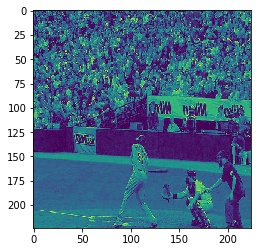

In [14]:
import torch
train_loader = dataset.build_data_loader(train=True, args={'batch_size': 5})
# print(len(train_loader))
for minibatch in train_loader:
    idxs, v,q,a,q_len = minibatch
    q = VQADataSet.batchify_questions(q)
    batch_size = len(q_len)
    print("\nminibatch:")
    print('idx', idxs)
    print('v: ', v.shape)
    print('a: ', a)
    print('q: ', q)
    for i in range(batch_size):
        idx_i = idxs[i]
        q_i = q[i]
        a_i = a[i].item()
        v_i = v[i].numpy()
        q_len_i = q_len[i]
        qj, aj = dataset.get(idx_i, 'train')
        
        qj_check = dataset.decode_question(q_i.tolist())
        qj_ans = " ".join(qj['tokens'])
        aj_check = str(dataset.decode_answer(a_i))
        aj_ans = str(aj['answer'])
        print(idx_i.item())
        print("\tcheck: " + qj_check)
        print("\tanswer: " + qj_ans)
        print("\tcheck: " + aj_check)
        print("\tanswer: " + aj_ans)
        assert(aj_ans == aj_check)
        assert(qj_ans in qj_check)
        img_v = v_i
#         img_v = img_v.reshape(224, 224, 3)
        imshow(img_v[0,:,:], interpolation='nearest')
        break
    break


In [7]:
x= 'data/val2014/COCO_val2014_000000262274.jpg'

print(os.path.exists(x))


True


In [8]:
#https://arxiv.org/pdf/1803.07724.pdf

In [9]:
# # pp(dataset.answer_maps)
# from random import shuffle
# from collections import defaultdict
# cntr = defaultdict(int)
# dist = defaultdict(list)
# for i, ann in enumerate(dataset.answer_maps):
#     ans = ann['answer']
#     cntr[ans]+=1
#     dist[ans].append(i)
#     split = {'train': [], 'test': []}
#     z_cnt = 0
#     for ans, idxes in dist.items():
#         shuffle(idxes)
#         c = int(len(idxes)*0.20)
#         split['train'] += idxes[c:]
#         split['test'] += idxes[:c]
#     split['test'].sort()
#     print(split['test'][:20])

In [10]:
print(dataset.itoq[0])
print(dataset.itoq[1])
print(dataset.itoq[2])
print(dataset.itoq[3])

print(dataset.qtoi['<pad>'])
print(dataset.qtoi['<start>'])
print(dataset.qtoi['<end>'])
print(dataset.qtoi['<unk>'])

<pad>
<start>
<end>
<unk>
0
1
2
3
